In [45]:
import tensorflow as tf
import tensorflow_probability.python.distributions as tfp
from collections import deque
import random as rand
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import gym

In [46]:
# define neural net Q_\theta(s,a) as a class

class Qfunction(object):
    
    def __init__(self, obssize, actsize, sess, optimizer):
        """
        obssize: dimension of state space
        actsize: dimension of action space
        sess: sess to execute this Qfunction
        optimizer: 
        """
        # build the prediction graph
        state = tf.placeholder(tf.float32, [None, obssize])
        initializer = tf.contrib.layers.xavier_initializer()
        
        W1 = tf.Variable(initializer([obssize,20]))
        b1 = tf.Variable(initializer([20]))
        W2 = tf.Variable(initializer([20, actsize]))
        b2 = tf.Variable(initializer([actsize]))

        h1 = tf.nn.sigmoid(tf.matmul(state, W1) + b1)
        h = tf.matmul(h1, W2) + b2
        
        Qvalues = h # (n,2) matrix
        Qvalues_probs = tf.nn.softmax(Qvalues)
        
        targets = tf.placeholder(tf.float32, [None])
        actions = tf.placeholder(tf.int32, [None])
        action_ohe = tf.one_hot(actions, actsize) # (n,2) - matrix
        batch_Q = tf.placeholder(tf.float32, [None, actsize]) # this gets a batch of [1,2] matrices
        historic_order = tf.placeholder(tf.float32, [None])
        
        historic_order_probs = tf.nn.softmax(historic_order)
        
        #########################   KL   ###########################

        X = tfp.Categorical(probs=Qvalues_probs)
        Y = tfp.Categorical(probs=batch_Q)
        distance = tfp.kl_divergence(X, Y)
        exploration_loss_KL = tf.tensordot(distance, historic_order_probs, axes=[0,0])
        
        #########################   L1   ###########################
        Dif_ = batch_Q - Qvalues_probs
        norm_L1 = tf.norm(Dif_, axis=1,  ord=1)
        exploration_loss_L1 = tf.tensordot(norm_L1, historic_order_probs, axes=[0,0])
        
        
        #########################   L2   ###########################
        norm_L2 = tf.norm(Dif_+1e-5, axis=1,  ord=2)
        exploration_loss_L2 = tf.tensordot(norm_L2, historic_order_probs, axes=[0,0])
        
        ########################   Linf   ###########################
        
        norm_Linf = tf.norm(Dif_, axis=1,  ord=np.inf)
        exploration_loss_Linf = tf.tensordot(norm_Linf, historic_order_probs, axes=[0,0])
        
        ########################   JS   #############################
        
        m = 0.5*(Qvalues_probs + batch_Q)
        M = tfp.Categorical(probs=m)
        X = tfp.Categorical(probs=Qvalues_probs)
        Y = tfp.Categorical(probs=batch_Q)
        JS = 0.5* tfp.kl_divergence(X, M) + tfp.kl_divergence(Y, M)
        exploration_loss_JS = tf.tensordot(JS, historic_order_probs, axes=[0,0])
        ############################################################

        
        Qpreds = tf.reduce_sum(Qvalues * action_ohe, axis=1)#elementwise multiplication here
        td_errors = targets - Qpreds
        
        loss = tf.reduce_mean(tf.square(td_errors))
        explore_alpha = tf.placeholder(tf.float32,[])
        loss_and_exploration_loss_KL = loss - explore_alpha*exploration_loss_KL
        loss_and_exploration_loss_L1 = loss - explore_alpha*exploration_loss_L1
        loss_and_exploration_loss_L2 = loss - explore_alpha*exploration_loss_L2
        loss_and_exploration_loss_Linf = loss - explore_alpha*exploration_loss_Linf
        loss_and_exploration_loss_JS = loss - explore_alpha*exploration_loss_JS

        # optimization
        self.train_explore_KL = optimizer.minimize(loss_and_exploration_loss_KL)
        self.train_explore_L1 = optimizer.minimize(loss_and_exploration_loss_L1)
        self.train_explore_L2 = optimizer.minimize(loss_and_exploration_loss_L2)
        self.train_explore_Linf = optimizer.minimize(loss_and_exploration_loss_Linf)
        self.train_explore_JS = optimizer.minimize(loss_and_exploration_loss_JS)
    
        # some bookkeeping
        self.Qvalues = Qvalues
        self.Qvalues_probs = Qvalues_probs 
        self.state = state
        self.actions = actions
        self.targets = targets
        self.batch_Q = batch_Q
        self.loss = loss
        self.explore_alpha = explore_alpha
        self.exploration_loss_KL = exploration_loss_KL
        self.exploration_loss_L1 = exploration_loss_L1
        self.exploration_loss_L2 = exploration_loss_L2
        self.exploration_loss_Linf = exploration_loss_Linf
        self.exploration_loss_JS = exploration_loss_JS
        self.historic_order = historic_order
        self.sess = sess
    
    def compute_Qvalues(self, states):
        """
        states: numpy array as input to the neural net, states should have
        size [numsamples, obssize], where numsamples is the number of samples
        output: Q values for these states. The output should have size 
        [numsamples, actsize] as numpy array
        """
        return self.sess.run(self.Qvalues, feed_dict={self.state: states})
    
    def compute_Qvalues_probs(self, states):
        """
        states: numpy array as input to the neural net, states should have
        size [numsamples, obssize], where numsamples is the number of samples
        output: Q values for these states. The output should have size 
        [numsamples, actsize] as numpy array
        """
        return self.sess.run(self.Qvalues_probs, feed_dict={self.state: states})

    def train(self, states, actions, targets):
        """
        states: numpy array as input to compute loss (s)
        actions: numpy array as input to compute loss (a)
        targets: numpy array as input to compute loss (Q targets)
        """
        return self.sess.run([self.loss,self.train_op], feed_dict={self.state:states, self.actions:actions,\
                                                                   self.targets:targets})
    
    def train_explore_(self, states, actions, targets, batch_Q, exploration_alpha, historic_order, distance_metric):
        """
        states: numpy array as input to compute loss (s)
        actions: numpy array as input to compute loss (a)
        targets: numpy array as input to compute loss (Q targets)
        batch_Q: numpy array as input to compute loss_explore
        exploration_alpha: numpy array as input to loss_and_exploration_loss
        
        """
        if distance_metric == "KL":
            return self.sess.run(self.train_explore_KL, feed_dict={self.state:states, self.actions:actions,\
                                                            self.targets:targets, self.batch_Q:batch_Q,\
                                                            self.explore_alpha:exploration_alpha,\
                                                            self.historic_order:historic_order})
        elif distance_metric == "L1":
            return self.sess.run(self.train_explore_L1, feed_dict={self.state:states, self.actions:actions,\
                                                            self.targets:targets, self.batch_Q:batch_Q,\
                                                            self.explore_alpha:exploration_alpha,\
                                                            self.historic_order:historic_order})
        elif distance_metric == "L2":
            return self.sess.run(self.train_explore_L2, feed_dict={self.state:states, self.actions:actions,\
                                                            self.targets:targets, self.batch_Q:batch_Q,\
                                                            self.explore_alpha:exploration_alpha,\
                                                            self.historic_order:historic_order})
        elif distance_metric == "Linf":
            return self.sess.run(self.train_explore_Linf, feed_dict={self.state:states, self.actions:actions,\
                                                            self.targets:targets, self.batch_Q:batch_Q,\
                                                            self.explore_alpha:exploration_alpha,\
                                                            self.historic_order:historic_order})
        elif distance_metric == "JS":
            return self.sess.run(self.train_explore_JS, feed_dict={self.state:states, self.actions:actions,\
                                                            self.targets:targets, self.batch_Q:batch_Q,\
                                                            self.explore_alpha:exploration_alpha,\
                                                            self.historic_order:historic_order})
    
    def compute_exploration_loss(self, states, actions, targets, batch_Q, historic_order, distance_metric):
        """
        states: numpy array as input to compute loss (s)
        actions: numpy array as input to compute loss (a)
        targets: numpy array as input to compute loss (Q targets)
        batch_Q: numpy array as input to compute loss_explore
        """
        if distance_metric == "KL":
            return self.sess.run(self.exploration_loss_KL, feed_dict={self.state:states, self.actions:actions,\
                                                               self.targets:targets, self.batch_Q:batch_Q,\
                                                               self.historic_order:historic_order})
        if distance_metric == "L1":
            return self.sess.run(self.exploration_loss_L1, feed_dict={self.state:states, self.actions:actions,\
                                                               self.targets:targets, self.batch_Q:batch_Q,\
                                                               self.historic_order:historic_order})
        if distance_metric == "L2":
            return self.sess.run(self.exploration_loss_L2, feed_dict={self.state:states, self.actions:actions,\
                                                               self.targets:targets, self.batch_Q:batch_Q,\
                                                               self.historic_order:historic_order})
        if distance_metric == "Linf":
            return self.sess.run(self.exploration_loss_Linf, feed_dict={self.state:states, self.actions:actions,\
                                                               self.targets:targets, self.batch_Q:batch_Q,\
                                                               self.historic_order:historic_order})
        if distance_metric == "JS":
            return self.sess.run(self.exploration_loss_Linf, feed_dict={self.state:states, self.actions:actions,\
                                                               self.targets:targets, self.batch_Q:batch_Q,\
                                                               self.historic_order:historic_order})
    

In [47]:
# Implement replay buffer
import random
class ReplayBuffer(object):
    
    def __init__(self, maxlength):
        """
        maxlength: max number of tuples to store in the buffer
        if there are more tuples than maxlength, pop out the oldest tuples
        """
        self.buffer = deque()
        self.number = 0
        self.maxlength = maxlength
    
    def append(self, experience):
        """
        this function implements appending new experience tuple
        experience: a tuple of the form (s,a,r,s^\prime)
        """
        self.buffer.append(experience)
        self.number += 1
        
    def pop(self):
        """
        pop out the oldest tuples if self.number > self.maxlength
        """
        while self.number > self.maxlength:
            self.buffer.popleft()
            self.number -= 1
    
    def sample(self, batchsize):
        """
        this function samples 'batchsize' experience tuples
        batchsize: size of the minibatch to be sampled
        return: a list of tuples of form (s,a,r,s^\prime)
        """
        batch = random.sample(self.buffer, batchsize)
            
        return batch
        

In [48]:
def build_target_update(from_scope, to_scope):
    """
    from_scope: string representing the scope of the network FROM which the variables will be copied
    to_scope: string representing the scope of the network TO which the variables will be copied
    """
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=from_scope)
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=to_scope)
    op = []
    for v1, v2 in zip(from_vars, to_vars):
        op.append(v2.assign(v1))
    return op    

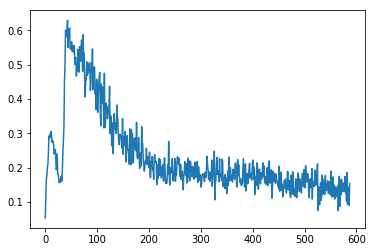

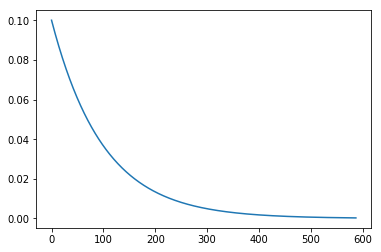

In [49]:
"""
Learning with exploration Div-DQN. Tune hyperparameters to optimize learning.
"""
# parameter initializations
lr = 1e-3  # learning rate for gradient update
batchsize = 64  # batchsize for buffer sampling
maxlength = 10000  # max number of tuples held by buffer
envname = "CartPole-v0"  # environment name
tau = 100  # time steps for target update
episodes = 1000  # number of episodes to run 
initialsize = 500  # initial time steps before start updating
epsilon = .05  # constant for exploration
gamma = .99  # discount
exploration_alpha = 0.1  #exploration parameter
delta = 0.05 # exploration weight in loss function. 0.05 is already quite optimized
distance_metric = "L1" # Options are: Linf, L1, L2, KL (for Kullback–Leibler divergence), JS (for Jensen–Shannon divergence)
distribution_buffer = "Unif" # Options are Unif, exp_high_recent, exp_high_old, reward_high
# initialize environment
env = gym.make(envname)
obssize = env.observation_space.low.size
actsize = env.action_space.n

################# DO NOT CHANGE THIS PART ###################
#wrapper for accounting rewards
rEpisode=0
rList=[]

def reset_decorate(func):
    def func_wrapper():
        global rList
        global rEpisode
        rList.append(rEpisode)
        rEpisode=0
        return(func())
    return func_wrapper

env.reset = reset_decorate(env.reset)

def step_decorate(func):
    def func_wrapper(action):
        global rEpisode
        s1, r, d, other = func(action)
        rEpisode+=r
        return(s1, r, d, other)
    return func_wrapper

env.step = step_decorate(env.step)

def init():
    rEpisode=0
    rList=[]
    return;
#########################################################

# initialize tensorflow session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# optimizer
optimizer = tf.train.AdamOptimizer(lr)

# initialize networks
with tf.variable_scope("principal"):
    Qprincipal = Qfunction(obssize, actsize, sess, optimizer)
with tf.variable_scope("target"):
    Qtarget = Qfunction(obssize, actsize, sess, optimizer)

# build ops
update = build_target_update("principal", "target")  # call sess.run(update) to copy
                                                     # from principal to target

# initialization of graph and buffer
sess.run(tf.global_variables_initializer())
buffer = ReplayBuffer(maxlength)
sess.run(update)
counter = 0
# main iteration
exploration_loss_log = np.array([])
exploration_alpha_log = np.array([])
rEpisode=0
rList=[]
for i in range(episodes):
    s = env.reset()
    d = False
    rsum = 0
    while not d:
       
        s_ = np.expand_dims(s, 0)
        
        if np.random.rand() < epsilon:
            a = env.action_space.sample()
         
        else:
            a = np.argmax(Qprincipal.compute_Qvalues(s_))
        
        s1, r, d, _ = env.step(a)
        
        rsum += r
        counter += 1
        Q = Qprincipal.compute_Qvalues_probs(s_)[0]
        if distribution_buffer == "Unif":
            counter_ = 0
        elif distribution_buffer == "exp_high_recent": # recent experience has a bigger historic order value
            counter_ = counter                         # e.g. 10 is a more recent experience than 5
        elif distribution_buffer == "exp_high_older": # older experience has a bigger historic order value                      
            counter_ = -counter                       # e.g. -5 is an older experience than -10
        elif distribution_buffer == "reward_high": # experience with high reward has a bigger historic order value                      
            counter_ = r          
        buffer.append((s, a, r, s1, d, Q, counter_))
       

        if (counter > initialsize):
            sample = buffer.sample(batchsize)
            sbatch = np.array([sam[0] for sam in sample])
            abatch = np.array([sam[1] for sam in sample])
            rbatch = np.array([sam[2] for sam in sample])
            s1_batch = np.array([sam[3] for sam in sample])
            d_batch = np.array([sam[4] for sam in sample])
            Q_batch = np.array([sam[5] for sam in sample])
            historic_order = np.array([sam[6] for sam in sample]) 
            targets = Qtarget.compute_Qvalues(s1_batch)
            target_ = rbatch + gamma*np.max(targets, 1)*(1-d_batch)
            if not counter%20:
                exploration_loss = Qprincipal.compute_exploration_loss(
                    sbatch, abatch, target_, Q_batch, historic_order, distance_metric)
                exploration_loss_log = np.append(exploration_loss_log, exploration_loss)
                exploration_alpha_log = np.append(exploration_alpha_log, exploration_alpha)
            
                if exploration_loss < delta:
                    exploration_alpha *= 1.01
                else:
                    exploration_alpha *= 0.99
                
            Qprincipal.train_explore_(
                sbatch, abatch, target_, Q_batch, exploration_alpha, historic_order, distance_metric)
            
            if (counter%tau == 0):
                sess.run(update)
                
        s = s1
plt.plot(exploration_loss_log)
plt.show()
plt.plot(exploration_alpha_log)
plt.show()

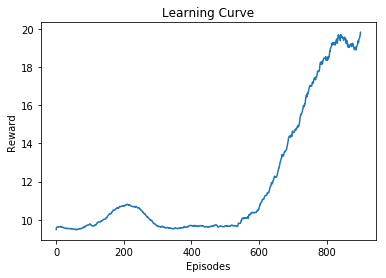

In [50]:
# Code Evaluation: DO NOT CHANGE CODE HERE

from numpy import convolve, ones
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'valid')
from pylab import plot
%matplotlib inline 

rm=movingaverage(rList, 100)
plot(rm)
plt.title("Learning Curve")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()

In [51]:
# Code Evaluation: DO NOT CHANGE CODE HERE
# after training, we will evaluate the performance of the agent
# on a target environment
eval_episodes = 100
record = []
env = gym.make('CartPole-v0')
eval_mode = True
for ite in range(eval_episodes):
    
    obs = env.reset()
    done = False
    rsum = 0
    
    while not done:
        if eval_mode:
            values = Qprincipal.compute_Qvalues(np.expand_dims(obs,0))
            action = np.argmax(values.flatten())
        else:
            raise NotImplementedError

        newobs, r, done, _ = env.step(action)
        rsum += r
        obs = newobs
    
    record.append(rsum)

print("eval performance of DQN agent: {}".format(np.mean(record)))

eval performance of DQN agent: 19.63
